# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles. 

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante : 
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test. 

Le notebook sera déposé sur la plateforme moodle du cours.

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


2024-12-22 22:26:06.047666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-22 22:26:06.084268: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-22 22:26:06.085193: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-22 22:26:06.759672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def Data():
    # Chemin principal des datasets
    base_dir = "mushrooms"
    test_dir = "test_mushrooms"
    
    # Répertoires pour les ensembles d'entraînement et de test
    train_dir = os.path.join(base_dir)
    test_dir = os.path.join(test_dir)
    
    # Classes (catégories)
    train_classes = os.listdir(train_dir)
    test_classes = os.listdir(test_dir)

    
    print("Classes d'entraînement:", train_classes)
    print("Classes de test:", test_classes)
    
    # Vérification des classes identiques entre train et test
    if set(train_classes) != set(test_classes):
        print("Attention : Les classes dans les ensembles d'entraînement et de test ne correspondent pas !")
    


    # Chargement des fichiers
    train_data = []
    for label in train_classes:
        # Exclure le dossier test
        image_files = os.listdir(os.path.join(train_dir, label))
        train_data.extend([(label, os.path.join(train_dir, label, f)) for f in image_files])
    
    test_data = []
    for label in test_classes:
        image_files = os.listdir(os.path.join(test_dir, label))
        test_data.extend([(label, os.path.join(test_dir, label, f)) for f in image_files])
    
    # Informations générales
    print("Nombre total d'images d'entraînement:", len(train_data))
    print("Nombre total d'images de test:", len(test_data))
    print("Nombre d'images par classe dans l'ensemble d'entraînement:",
          {label: len(os.listdir(os.path.join(train_dir, label))) for label in train_classes if label != "test"})
    print("Nombre d'images par classe dans l'ensemble de test:",
          {label: len(os.listdir(os.path.join(test_dir, label))) for label in test_classes})
    
    return train_data, test_data

In [3]:
train_data, test_data = Data()

Classes d'entraînement: ['amanita', 'crimini', 'oyster']
Classes de test: ['amanita', 'crimini', 'oyster']
Nombre total d'images d'entraînement: 13167
Nombre total d'images de test: 1470
Nombre d'images par classe dans l'ensemble d'entraînement: {'amanita': 4179, 'crimini': 4165, 'oyster': 4823}
Nombre d'images par classe dans l'ensemble de test: {'amanita': 520, 'crimini': 416, 'oyster': 534}


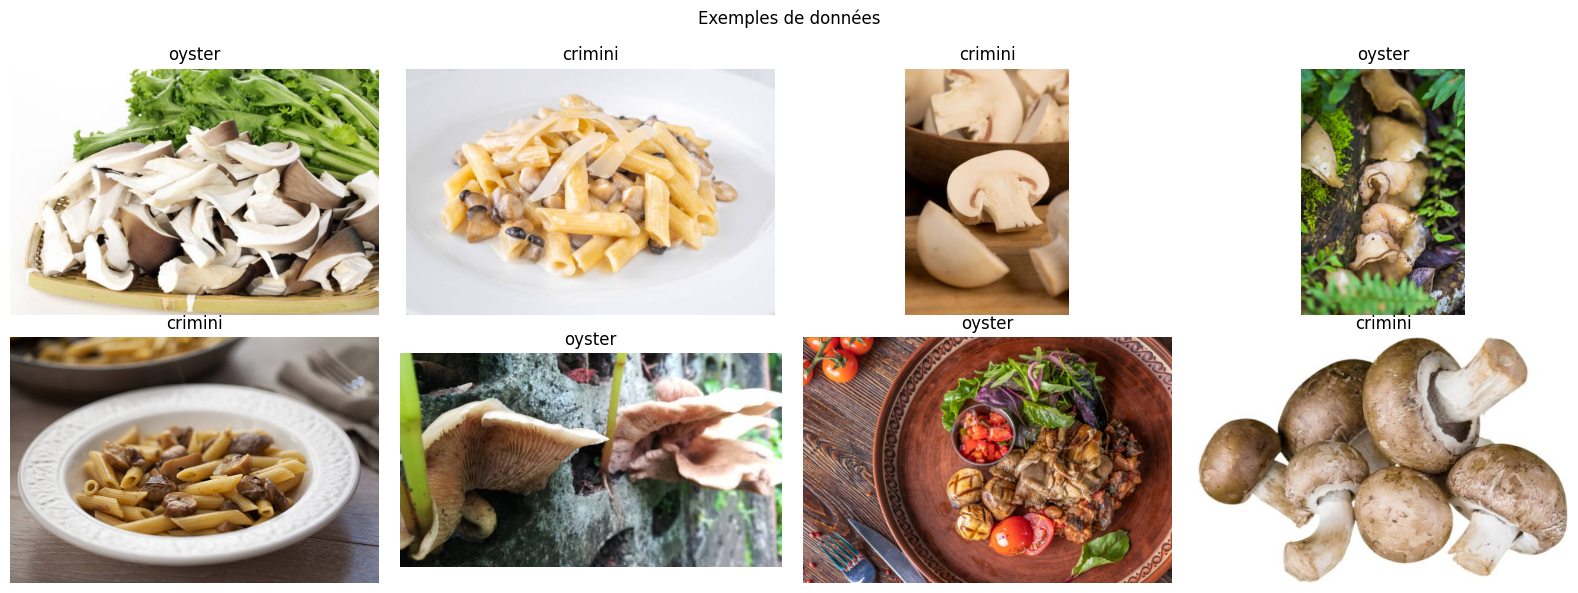

In [4]:
image_samples = np.random.randint(0,high=len(train_data)-1, size=8)

fig = plt.figure(figsize=(16,6))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(2,4,i+1)
    axs.set_title(train_data[img_idx][0])
    image = Image.open(train_data[img_idx][1])
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Exemples de données")
plt.tight_layout()

## Generation de variation d'image

In [5]:
# Dimensions des images
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Générateur de données pour l'entraînement et la validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,       # Normalisation des pixels (0-1)
    rotation_range=20,     # Rotation aléatoire des images
    width_shift_range=0.2, # Décalage horizontal
    height_shift_range=0.2,# Décalage vertical
    shear_range=0.2,       # Transformation en cisaillement
    zoom_range=0.2,        # Zoom
    horizontal_flip=True,  # Flip horizontal
    fill_mode='nearest'    # Mode de remplissage
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalisation uniquement

# Préparation des ensembles d'entraînement et de test
train_dir = "mushrooms"  # Chemin des données d'entraînement
test_dir = "test_mushrooms"  # Chemin des données de test

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Plusieurs classes
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print(f"Nombre total d'images dans le jeu d'entraînement : {train_generator.samples}")
print(f"Nombre total d'images dans le jeu de test : {test_generator.samples}")

Found 13167 images belonging to 3 classes.
Found 1470 images belonging to 3 classes.
Nombre total d'images dans le jeu d'entraînement : 13167
Nombre total d'images dans le jeu de test : 1470


## Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Bloc de convolution 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloc de convolution 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloc de convolution 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloc de convolution 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloc de convolution 5 (plus profond pour mieux capturer les caractéristiques complexes)
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Global Average Pooling (plus efficace pour réduire les paramètres que Flatten)
    model.add(GlobalAveragePooling2D())

    # Fully Connected Layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))  # Régularisation
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Régularisation
    model.add(Dense(num_classes, activation='softmax'))  # Couche de sortie

    return model

# Création du modèle
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)  # Images en couleur
num_classes = train_generator.num_classes
model = create_cnn_model(input_shape, num_classes)

# Compilation du modèle
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Résumé du modèle
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       


2024-12-22 22:26:10.171342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-22 22:26:10.291274: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 batch_nor

## Callback

In [7]:
from tensorflow.keras.callbacks import Callback

class SaveEveryNEpochs(Callback):
    def __init__(self, save_freq, model, save_path):
        super(SaveEveryNEpochs, self).__init__()
        self.save_freq = save_freq
        self.model_to_save = model
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            filepath = self.save_path.format(epoch=epoch + 1)
            self.model_to_save.save(filepath)
            print(f"Model saved at {filepath}")

## Train

In [8]:
EPOCHS = 5000
print("GPU disponible :", tf.config.list_physical_devices('GPU'))
model = load_model('mushroom_classifier_model.h5')

# Utilisation
save_every_5_epochs = SaveEveryNEpochs(
    save_freq=1, 
    model=model, 
    save_path="model/model_epoch_{epoch:02d}.h5"
)

# Entraînement avec le callback personnalisé
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[save_every_5_epochs]
)

GPU disponible : []
Epoch 1/5000
 20/412 [>.............................] - ETA: 11:54 - loss: 0.1894 - accuracy: 0.9219

KeyboardInterrupt: 

## Load pre-trained CNN

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

EPOCHS = 20

# Charger le modèle MobileNetV2 sans la dernière couche (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Geler les couches convolutionnelles
base_model.trainable = False  # Si vous voulez fine-tuner, mettez `True`

# Ajouter des couches spécifiques à votre tâche
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

save_every_n_epochs = SaveEveryNEpochs(
    save_freq=1, 
    model=model, 
    save_path="model/model_epoch_{epoch:02d}.h5"
)

# Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entraîner le modèle
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[save_every_n_epochs]
)

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/20
412/412 [==============================] - ETA: 0s - loss: 0.7141 - accuracy: 0.6854

/home/xerneas02/.local/lib/python3.9/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/xerneas02/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at model/model_epoch_01.h5
412/412 [==============================] - 171s 407ms/step - loss: 0.7141 - accuracy: 0.6854 - val_loss: 0.3554 - val_accuracy: 0.8694
Epoch 2/20
412/412 [==============================] - 166s 402ms/step - loss: 0.5737 - accuracy: 0.7431 - val_loss: 0.3201 - val_accuracy: 0.8707
Epoch 3/20
412/412 [==============================] - 170s 413ms/step - loss: 0.5420 - accuracy: 0.7680 - val_loss: 0.3216 - val_accuracy: 0.8755
Epoch 4/20
412/412 [==============================] - 187s 453ms/step - loss: 0.5361 - accuracy: 0.7665 - val_loss: 0.3241 - val_accuracy: 0.8782
Epoch 5/20
412/412 [==============================] - 174s 421ms/step - loss: 0.5227 - accuracy: 0.7721 - val_loss: 0.3450 - val_accuracy: 0.8776
Epoch 6/20
412/412 [==============================] - 165s 401ms/step - loss: 0.5141 - accuracy: 0.7789 - val_loss: 0.3161 - val_accuracy: 0.8796
Epoch 7/20
412/412 [==============================] - 166s 404ms/step - loss: 0.5004 - accuracy:

## Save

In [12]:
# After training your model
model.save('mushroom_classifier_model.h5')

## Load

In [11]:
model = load_model('mushroom_classifier_model.h5')

## Test

46/46 [==============================] - 19s 417ms/step - loss: 0.3052 - accuracy: 0.8837
Précision sur l'ensemble de test: 0.88


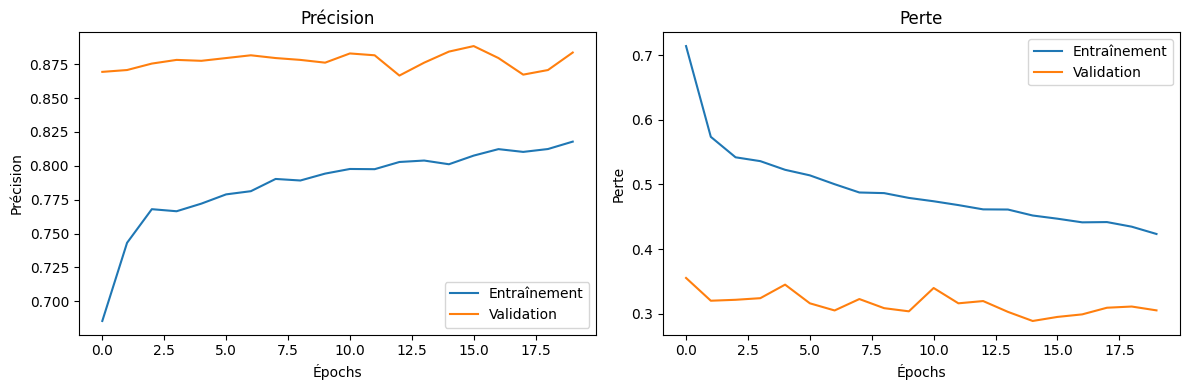

In [13]:
# Évaluation sur les données de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Précision sur l'ensemble de test: {test_acc:.2f}")

# Visualisation des courbes de précision et de perte
plt.figure(figsize=(12, 4))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

Found 1470 images belonging to 3 classes.
46/46 [==============================] - 20s 419ms/step


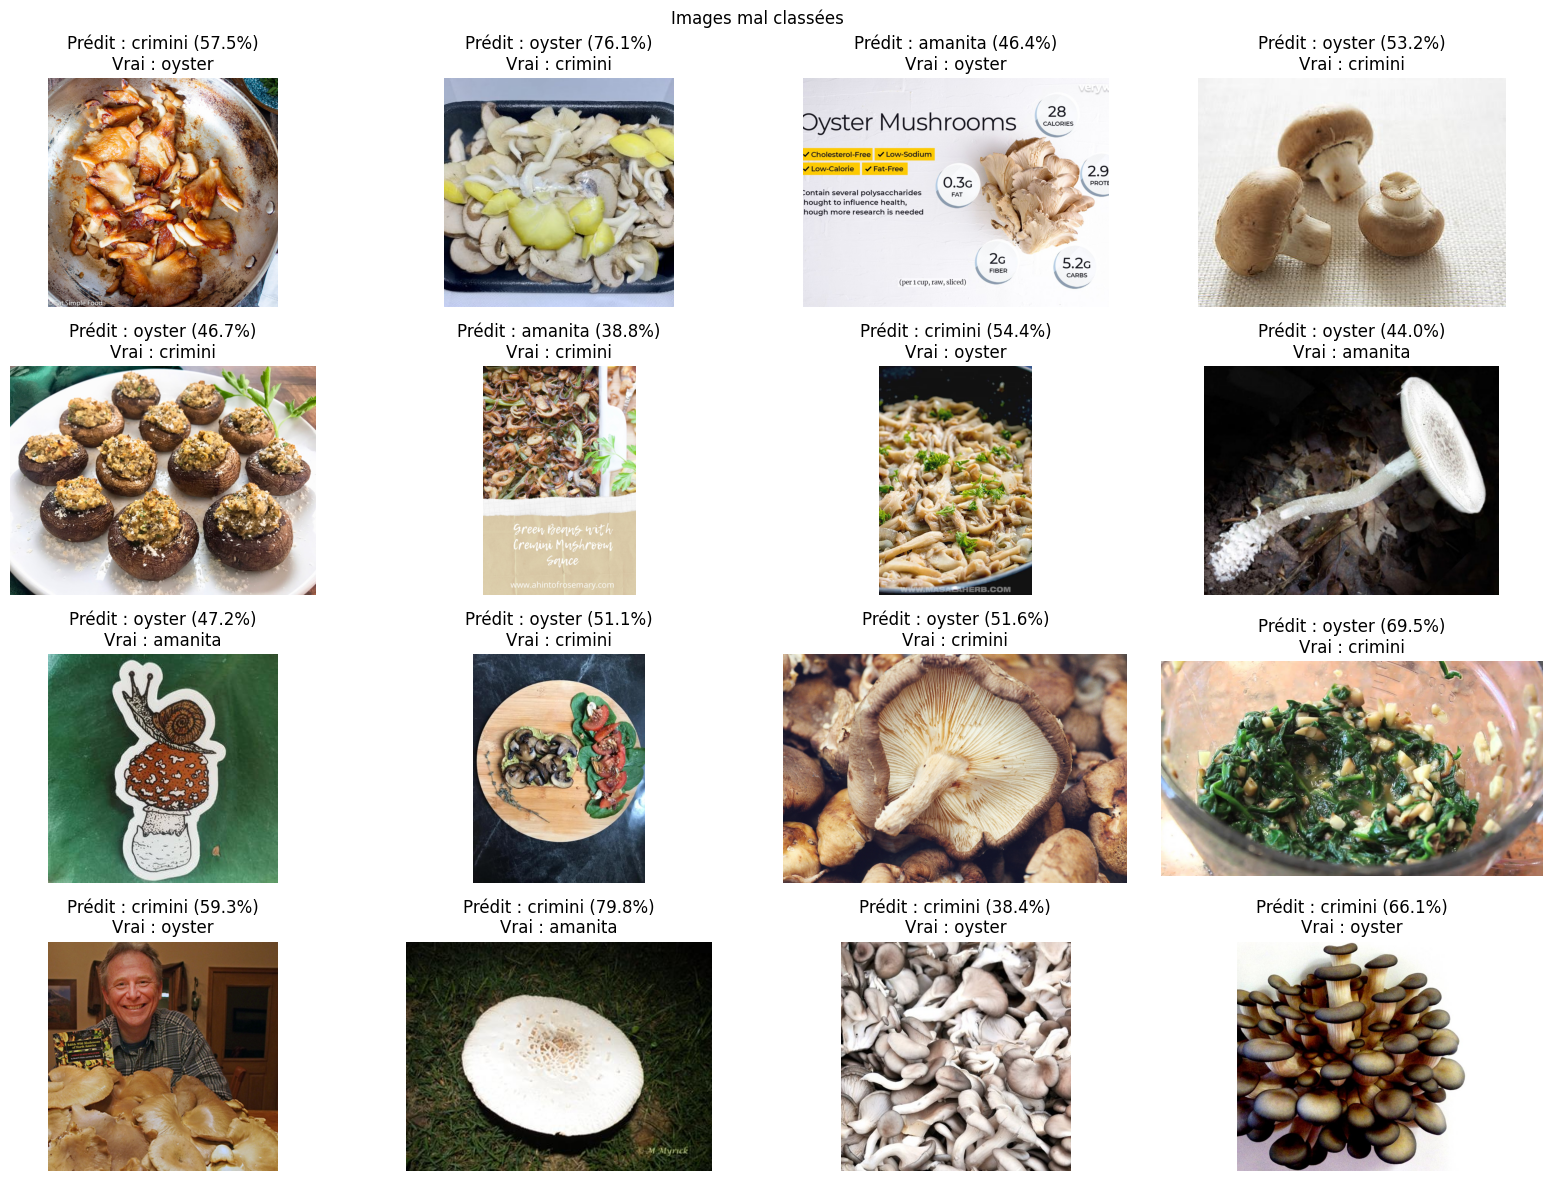

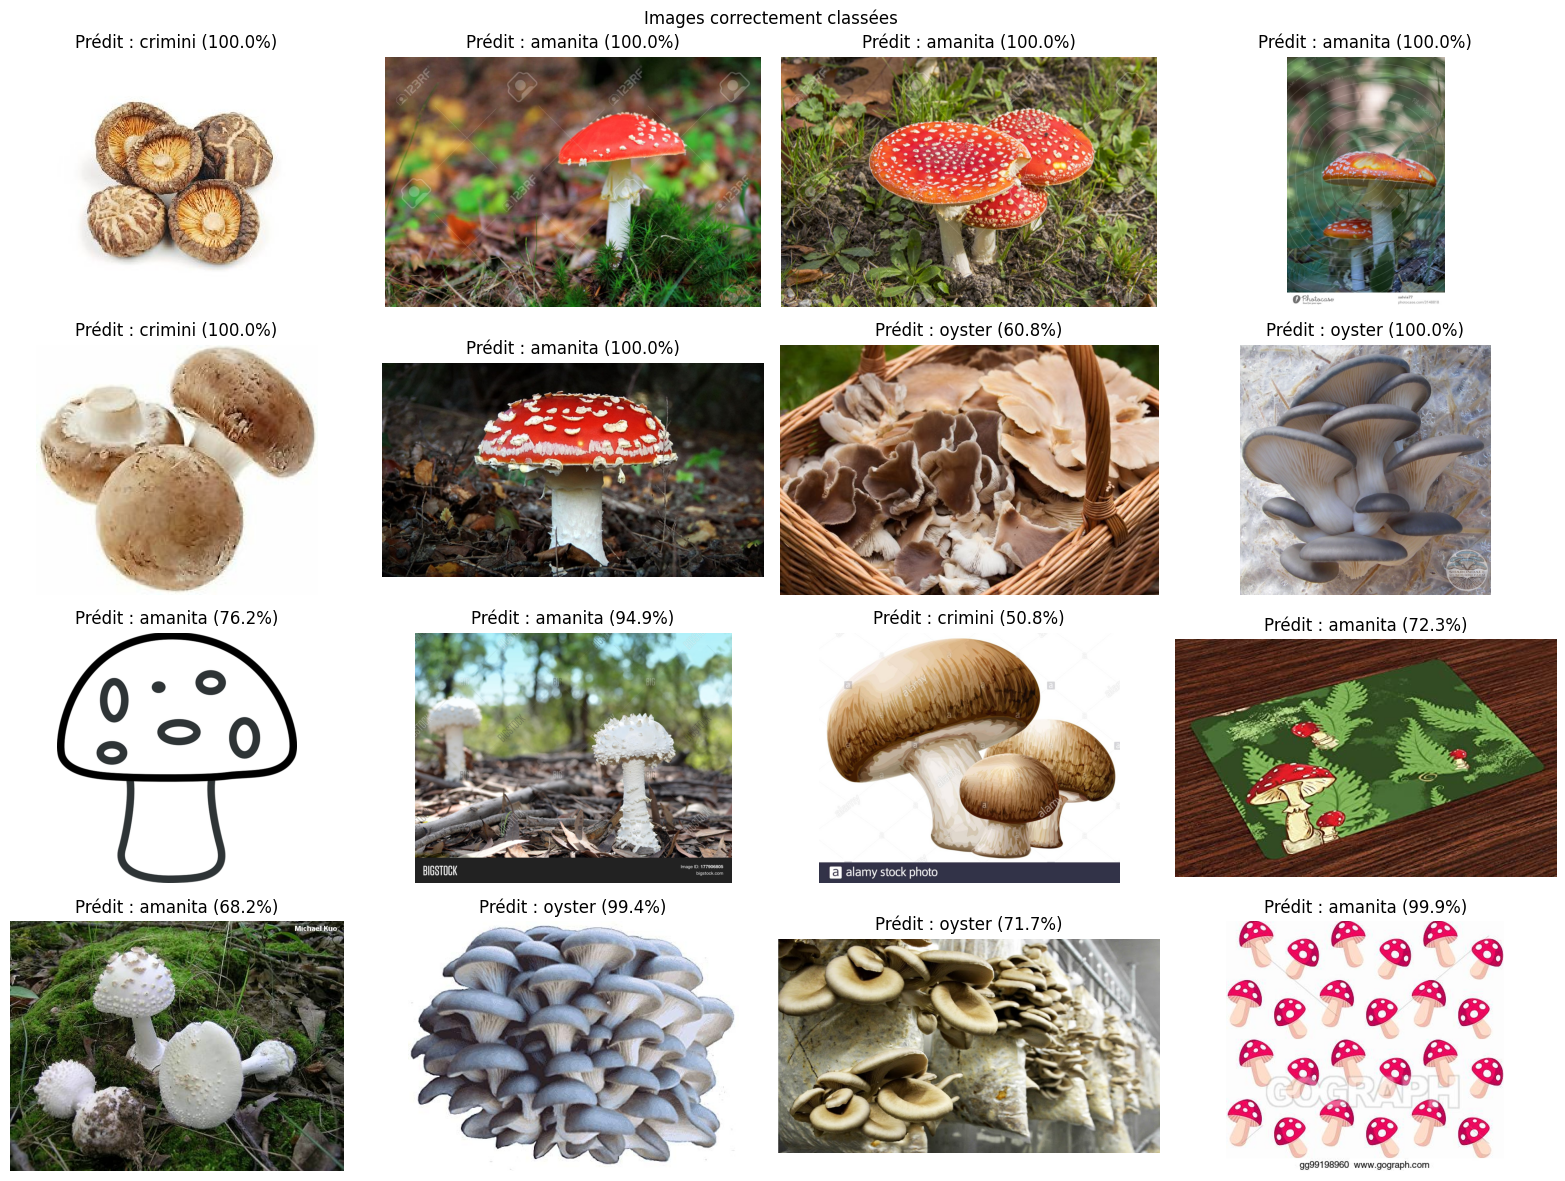

Taux de réussite global : 88.37%
Taux de réussite par catégorie :
  - amanita : 93.46%
  - crimini : 82.93%
  - oyster : 87.64%


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Générateur de données pour le test
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Obtenir les noms des classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Prédictions du modèle sur les données de test
Y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred_confidence = np.max(Y_pred, axis=1)  # Taux de confiance pour chaque prédiction

# Étiquettes vraies
y_true = test_generator.classes

# Trouver les indices des prédictions correctes et incorrectes
correct = np.where(y_pred == y_true)[0]
incorrect = np.where(y_pred != y_true)[0]

# Calcul du taux de réussite global
accuracy = len(correct) / len(y_true) * 100

# Calcul du taux de réussite par catégorie
category_accuracy = {}
for class_name in class_names:
    class_idx = class_indices[class_name]
    total_in_class = np.sum(y_true == class_idx)
    correct_in_class = np.sum((y_true == class_idx) & (y_pred == class_idx))
    if total_in_class > 0:
        category_accuracy[class_name] = correct_in_class / total_in_class * 100
    else:
        category_accuracy[class_name] = None  # Si aucune image dans la classe

# Fonction pour afficher les images avec le taux de confiance
def display_images(indices, title):
    num_samples = 16  # Nombre d'images à afficher
    if len(indices) < num_samples:
        num_samples = len(indices)
    image_samples = np.random.choice(indices, size=num_samples, replace=False)
    
    fig = plt.figure(figsize=(16, 12))
    for i, idx in enumerate(image_samples):
        axs = fig.add_subplot(4, 4, i+1)
        image_path = test_generator.filepaths[idx]
        image = Image.open(image_path)
        plt.imshow(image)
        
        confidence = y_pred_confidence[idx] * 100  # Convertir en pourcentage
        
        if title == "Images mal classées":
            axs.set_title(f"Prédit : {class_names[y_pred[idx]]} ({confidence:.1f}%)\nVrai : {class_names[y_true[idx]]}")
        else:
            axs.set_title(f"Prédit : {class_names[y_pred[idx]]} ({confidence:.1f}%)")
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Afficher des images où le modèle s'est trompé avec le taux de confiance
display_images(incorrect, "Images mal classées")

# Afficher des images où le modèle a correctement prédit avec le taux de confiance
display_images(correct, "Images correctement classées")

# Affichage des taux de réussite
print(f"Taux de réussite global : {accuracy:.2f}%")
print("Taux de réussite par catégorie :")
for class_name, acc in category_accuracy.items():
    if acc is not None:
        print(f"  - {class_name} : {acc:.2f}%")
    else:
        print(f"  - {class_name} : Pas d'images dans cette catégorie")
